# Autoencoders

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
# convert MNIST vec to img
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [18]:
# displaying routine for autoencoder (batch at a time)
def display_images(ae_in, ae_out, n=1):
    for N in range(n):
        if ae_in is not None:
            in_pic = to_img(ae_in.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1, 4, i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
                
        out_pic = to_img(ae_out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

# Data loading

In [4]:

batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = MNIST('./data', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
device = torch.device('cuda:0')

# Define model

In [29]:
class Autoencoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Optimization

## Standard autoencoder

In [31]:
d = 30
model = Autoencoder(d).to(device)
criterion = nn.MSELoss()


learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

Epoch [1/20] loss: 0.1972
Epoch [2/20] loss: 0.1463
Epoch [3/20] loss: 0.1175
Epoch [4/20] loss: 0.1075


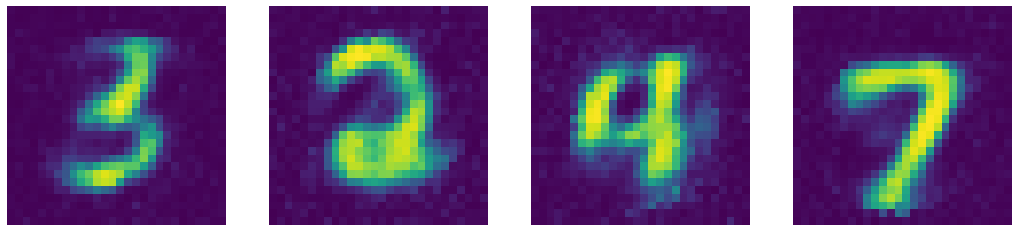

Epoch [5/20] loss: 0.0954
Epoch [6/20] loss: 0.0858
Epoch [7/20] loss: 0.0748
Epoch [8/20] loss: 0.0816


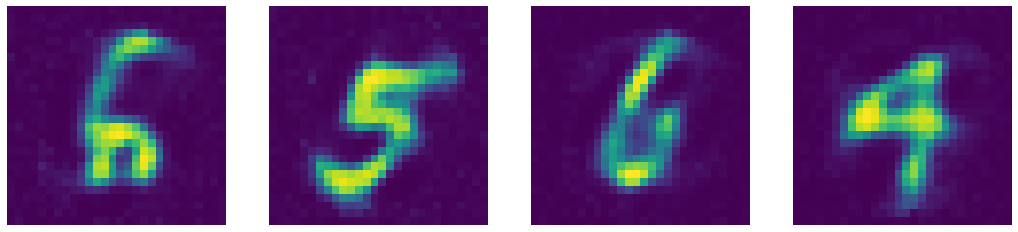

Epoch [9/20] loss: 0.0744
Epoch [10/20] loss: 0.0810
Epoch [11/20] loss: 0.0682
Epoch [12/20] loss: 0.0643


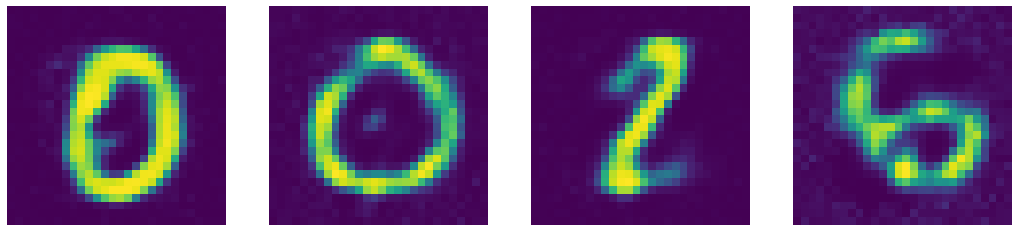

Epoch [13/20] loss: 0.0599
Epoch [14/20] loss: 0.0642
Epoch [15/20] loss: 0.0635
Epoch [16/20] loss: 0.0590


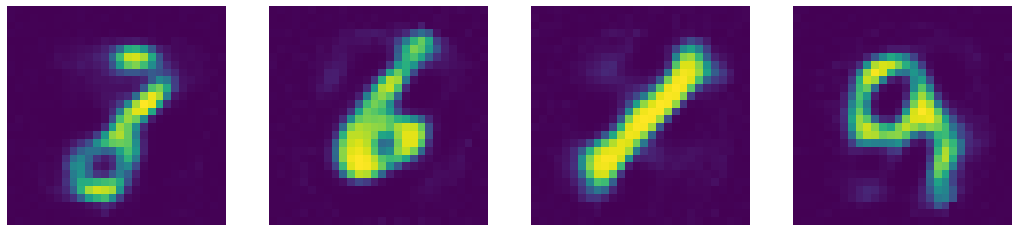

Epoch [17/20] loss: 0.0607
Epoch [18/20] loss: 0.0624
Epoch [19/20] loss: 0.0550
Epoch [20/20] loss: 0.0605


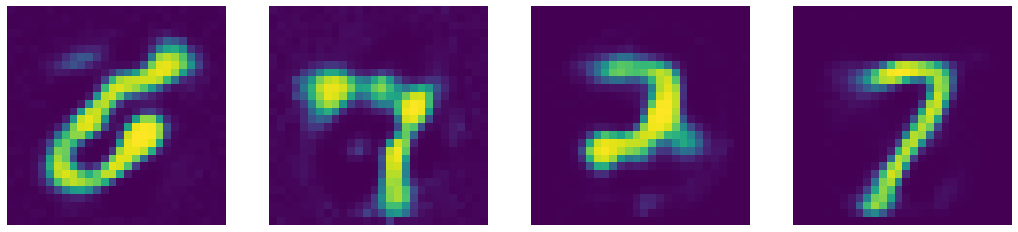

In [32]:
# train standard autoencoder
num_epochs = 20

for epoch in range(num_epochs):
    for img, _ in dataloader:
        
        img = img.to(device)
        img = img.view(img.size(0), -1) # unravel
        
        # forward
        output = model(img)
        loss = criterion(output, img.data)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # log
    print(f'Epoch [{epoch+1}/{num_epochs}] loss: {loss.item():.4f}')
    if (epoch+1) % 4 == 0:
        display_images(None, output)
        plt.show()

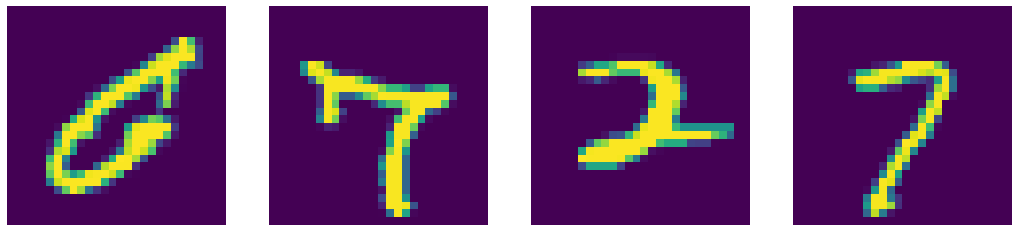

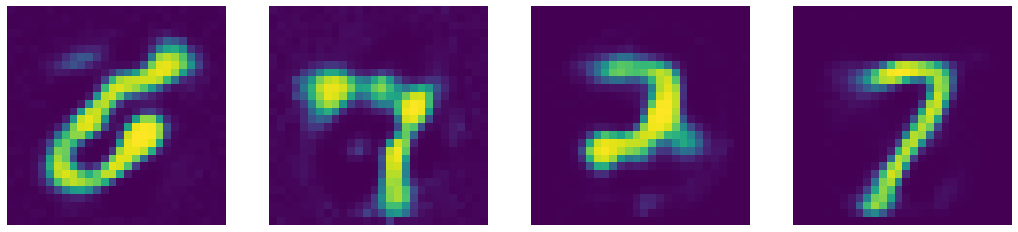

In [33]:
display_images(img, output)

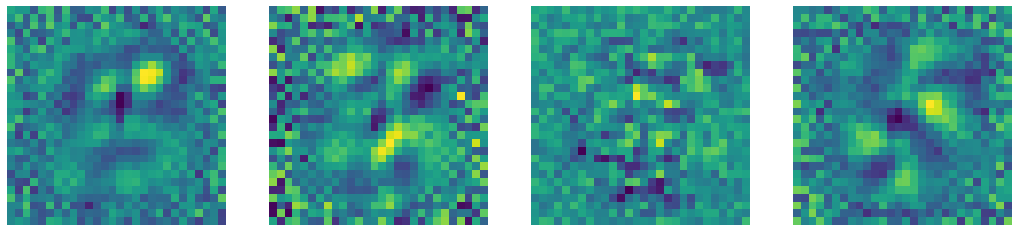

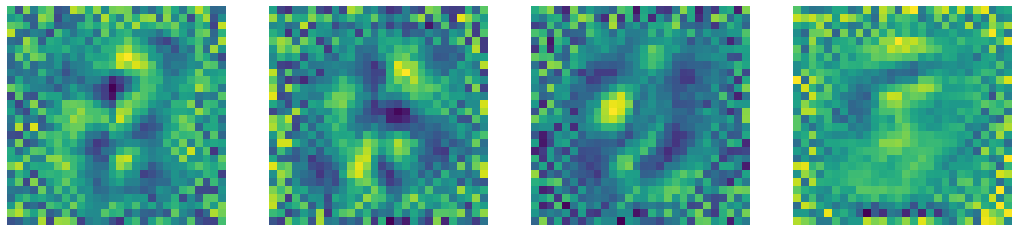

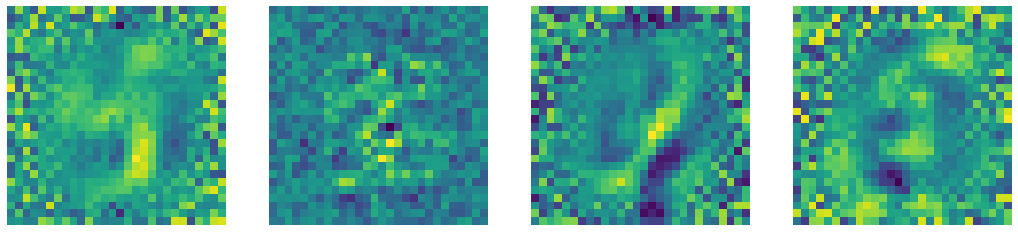

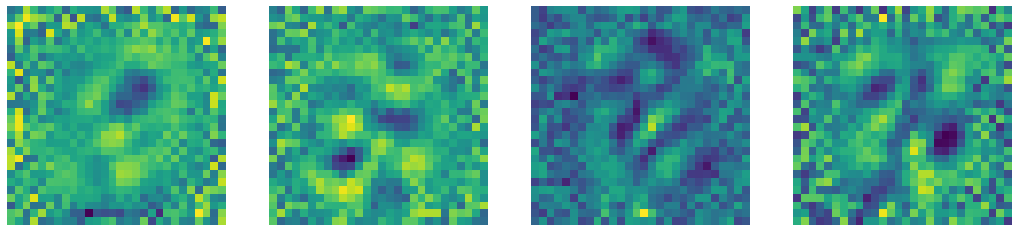

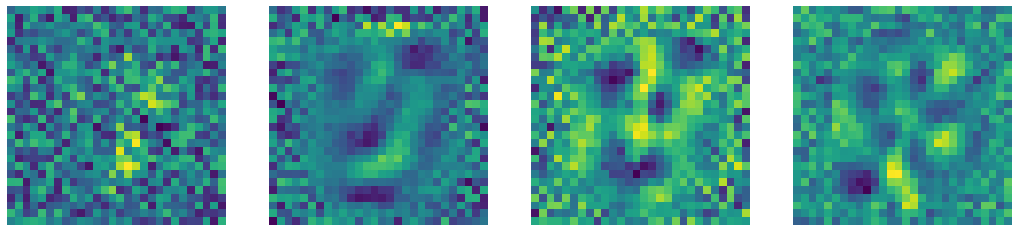

In [34]:
# visualize a few kernels?
display_images(None, model.encoder[0].weight, 5)

## Denoising autoencoder

Epoch [1/20, loss: 0.9034]
Epoch [2/20, loss: 0.8410]
Epoch [3/20, loss: 0.8093]
Epoch [4/20, loss: 0.7913]


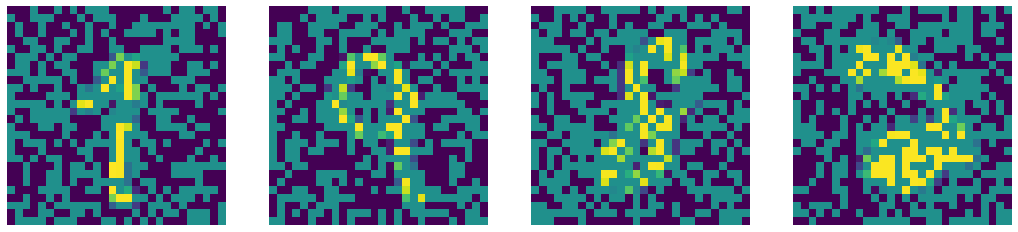

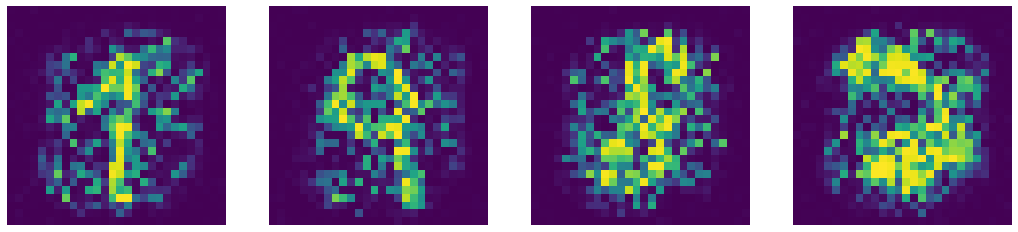

Epoch [5/20, loss: 0.7805]
Epoch [6/20, loss: 0.7666]
Epoch [7/20, loss: 0.7505]
Epoch [8/20, loss: 0.7447]


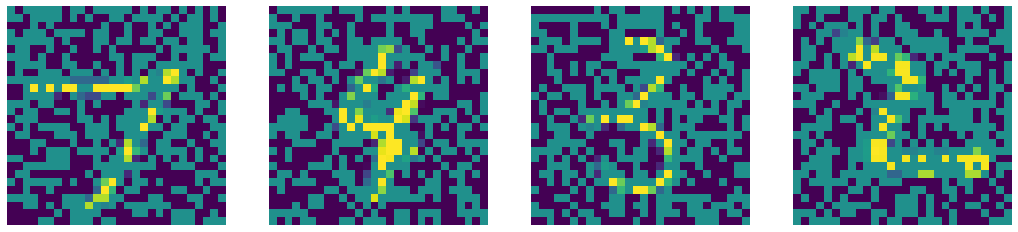

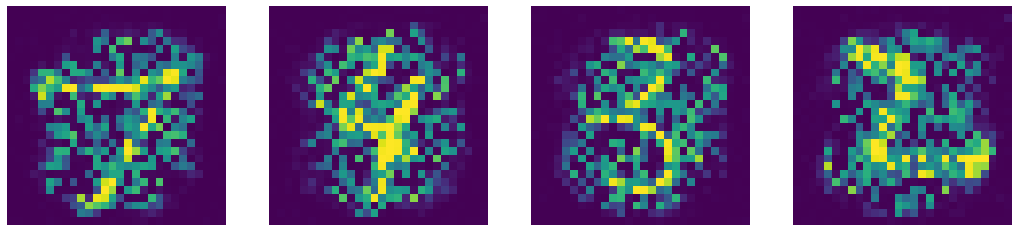

Epoch [9/20, loss: 0.7314]
Epoch [10/20, loss: 0.7230]
Epoch [11/20, loss: 0.7126]
Epoch [12/20, loss: 0.7037]


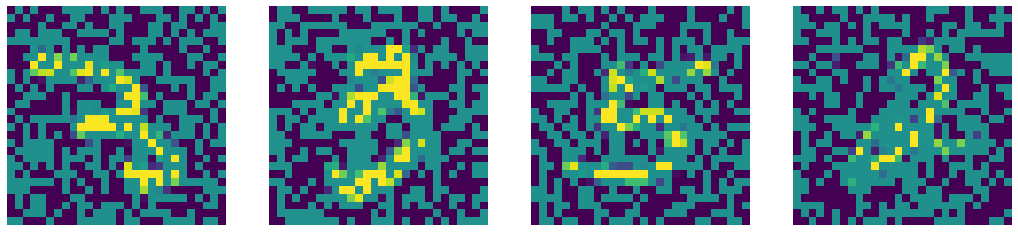

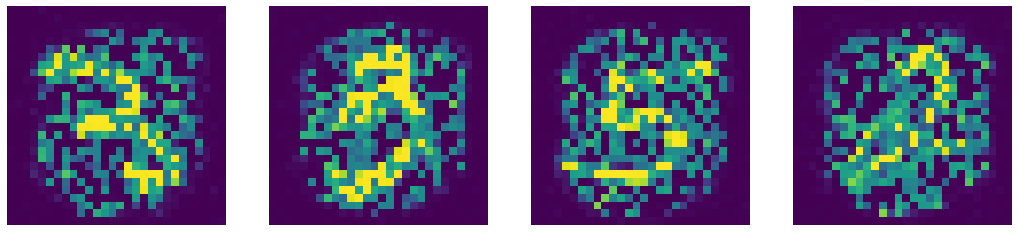

Epoch [13/20, loss: 0.6924]
Epoch [14/20, loss: 0.6866]
Epoch [15/20, loss: 0.6810]
Epoch [16/20, loss: 0.6729]


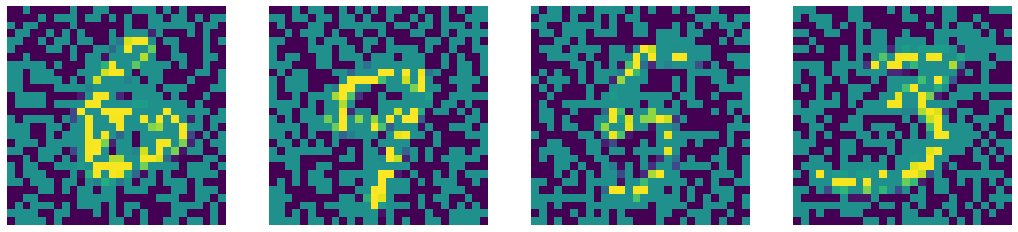

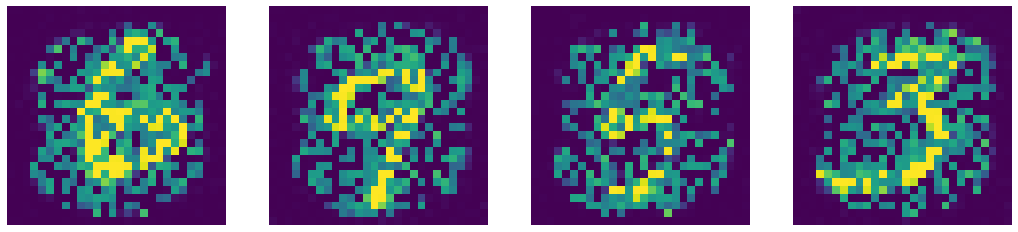

Epoch [17/20, loss: 0.6698]
Epoch [18/20, loss: 0.6673]
Epoch [19/20, loss: 0.6654]
Epoch [20/20, loss: 0.6642]


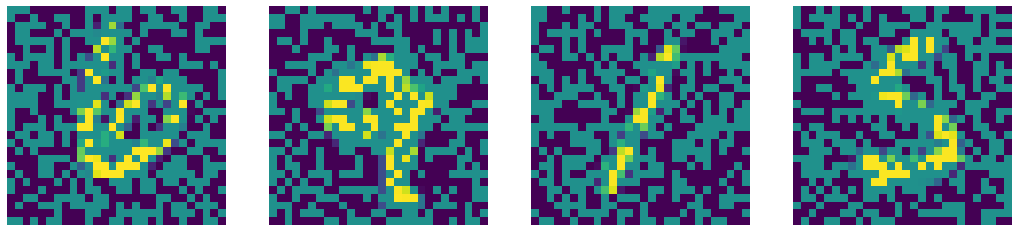

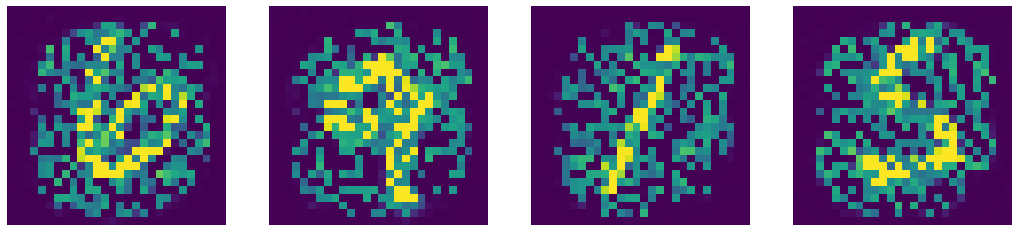

In [35]:
num_epochs = 20

# corrupt images with 50% Dropout
do = nn.Dropout()

# increase number of hidden neurons for denoising AE
d = 500
model = Autoencoder(d).to(device)
criterion = nn.MSELoss()

# reload optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

for epoch in range(num_epochs):
    for img, _ in dataloader:
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        
        # introduce noisy img
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)
        
        # forward (feeding dropout image)
        output = model(img_bad)
        loss = criterion(output, img_bad.data)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # log + plot denoising AE
    print(f'Epoch [{epoch+1}/{num_epochs}, loss: {loss.item():.4f}]')
    
    if (epoch+1) % 4 == 0:
        display_images(img_bad, output)
        plt.show()

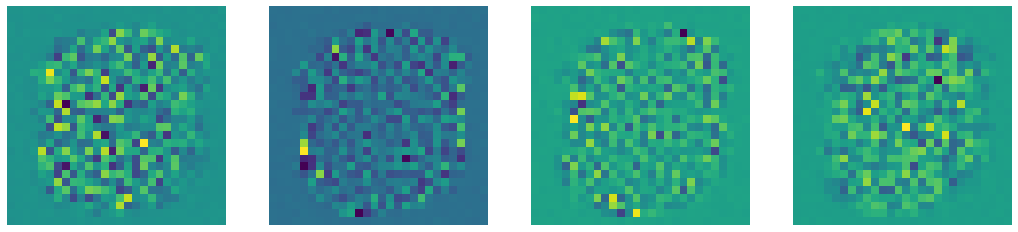

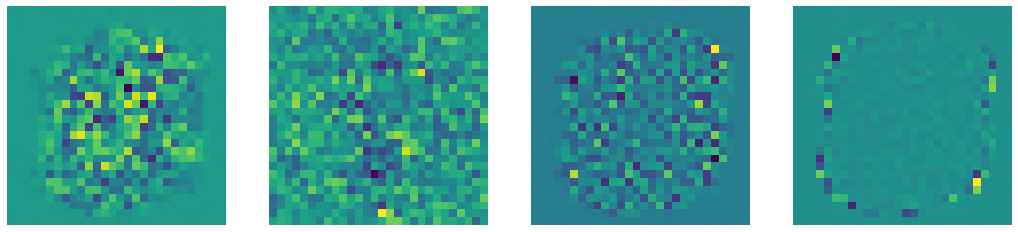

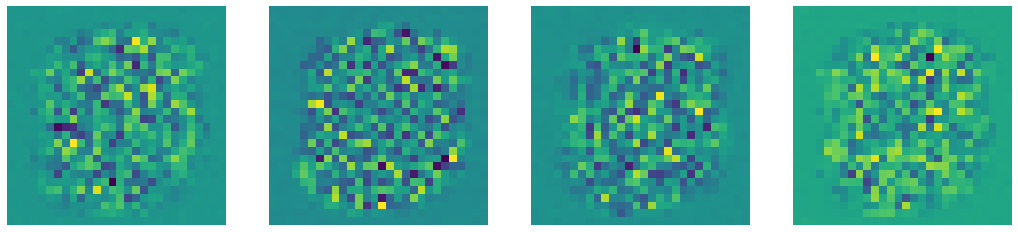

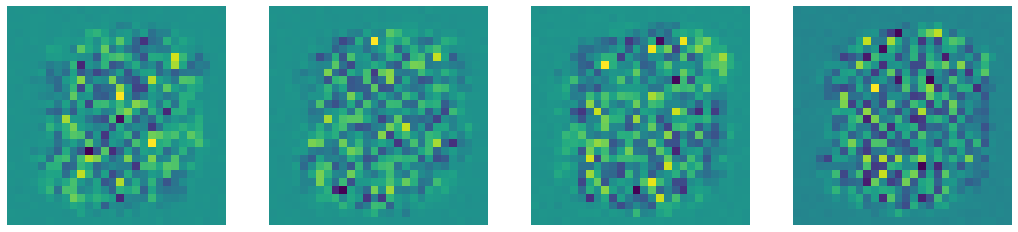

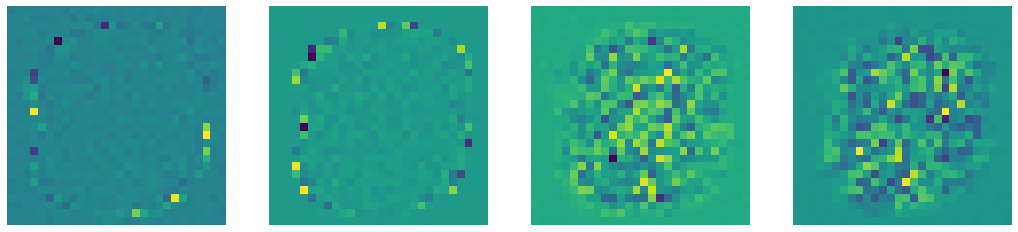

In [36]:
display_images(None, model.encoder[0].weight, 5)

# Compare with CV inpainting methods

In [38]:
from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA

In [39]:
dst_TELEA = list()    # Telea method
dst_NS = list()       # Navier-Stokes

for i in range(3, 7):
    corrupted_img = ((img_bad.data.cpu()[i].view(28, 28) / 4 + 0.5) * 255).byte().numpy()
    mask = 2 - noise.cpu()[i].view(28, 28).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))
    
tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]

TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

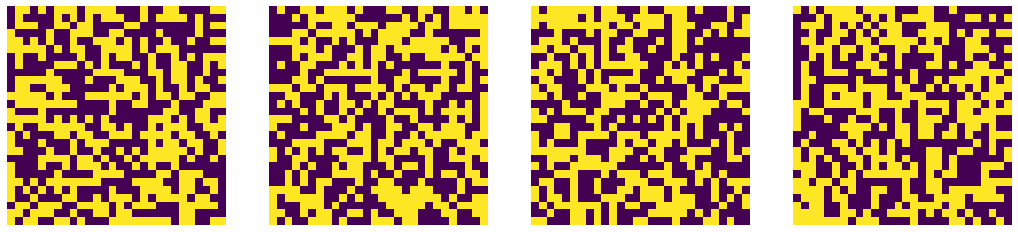

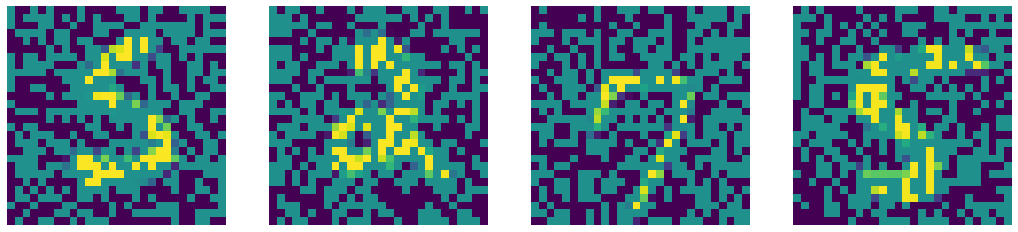

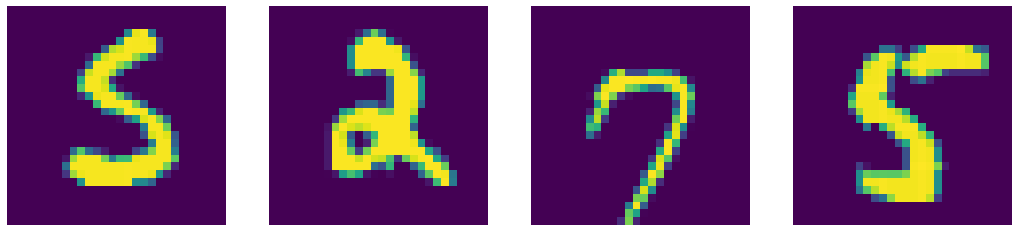

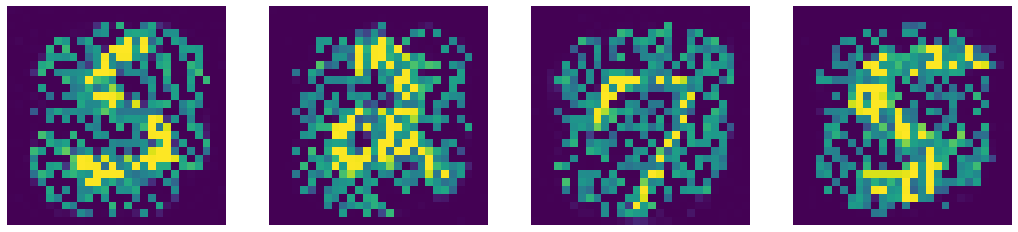

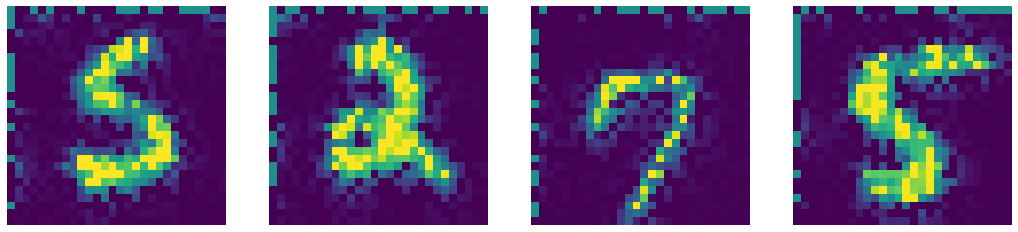

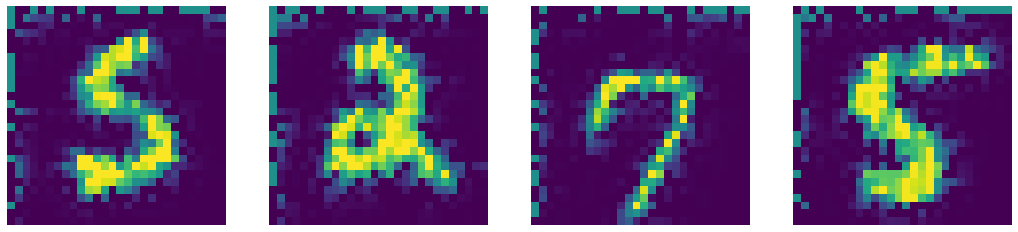

In [41]:
# compare results
with torch.no_grad():
    display_images(noise[3:7], img_bad[3:7])
    display_images(img[3:7], output[3:7])
    display_images(TELEA, NS)

# Make CNN autoencoder


In [76]:
# note: ReLU doesn't work well! But why?
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, n_feat):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(1, n_feat, kernel_size=5),
            nn.Tanh(), 
            nn.Conv2d(n_feat, 2*n_feat, kernel_size=5),
            nn.Tanh(),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(2*n_feat, n_feat, kernel_size=5),
            nn.Tanh(),
            nn.ConvTranspose2d(n_feat, 1, kernel_size=5),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.encode(x)
        x = self.decode(x)
        return x

Epoch [1/20, loss: 0.6185]
Epoch [2/20, loss: 0.5493]
Epoch [3/20, loss: 0.5170]
Epoch [4/20, loss: 0.4987]


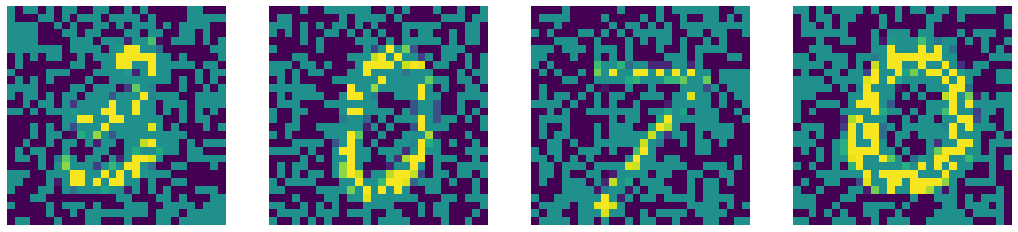

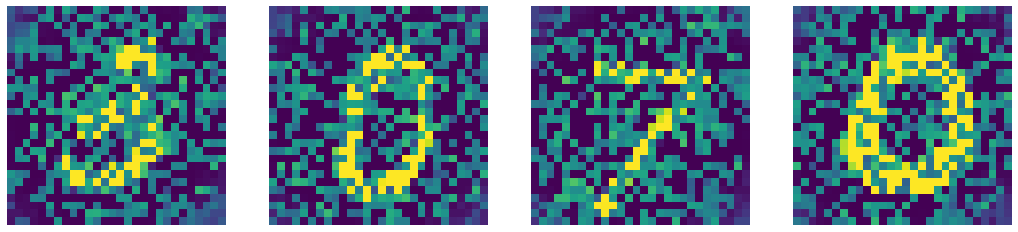

Epoch [5/20, loss: 0.4851]
Epoch [6/20, loss: 0.4763]
Epoch [7/20, loss: 0.4705]
Epoch [8/20, loss: 0.4655]


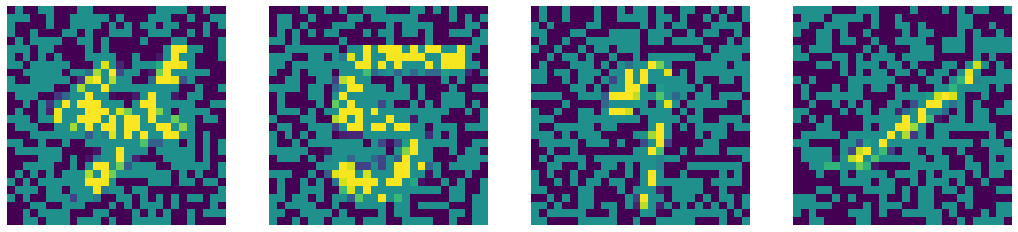

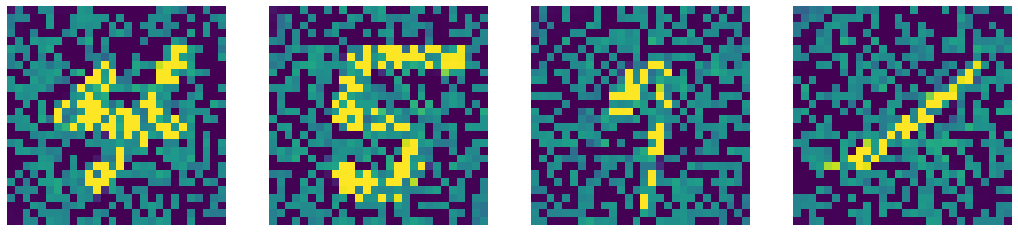

Epoch [9/20, loss: 0.4631]
Epoch [10/20, loss: 0.4605]
Epoch [11/20, loss: 0.4596]
Epoch [12/20, loss: 0.4622]


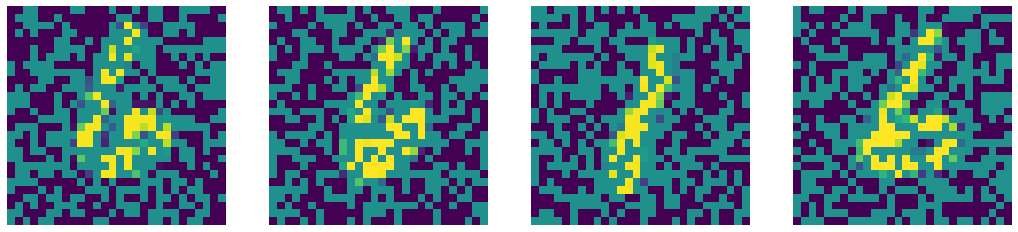

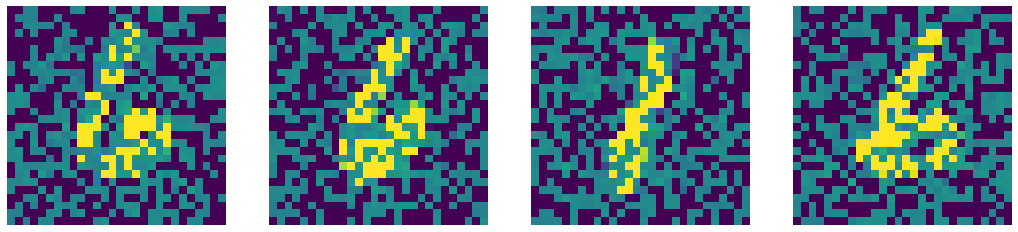

Epoch [13/20, loss: 0.4556]
Epoch [14/20, loss: 0.4551]
Epoch [15/20, loss: 0.4601]
Epoch [16/20, loss: 0.4606]


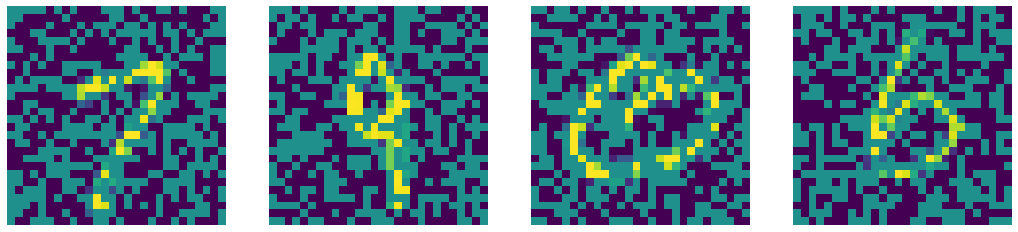

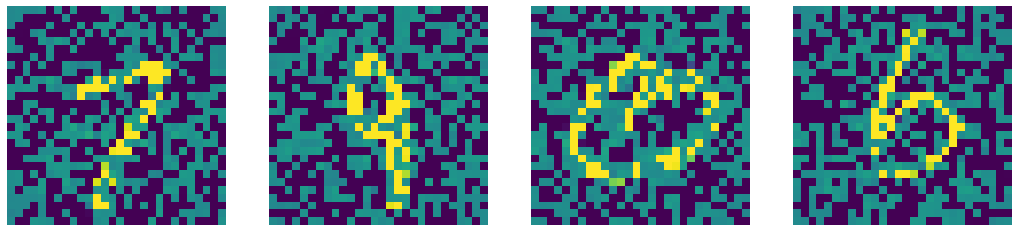

Epoch [17/20, loss: 0.4561]
Epoch [18/20, loss: 0.4564]
Epoch [19/20, loss: 0.4557]
Epoch [20/20, loss: 0.4583]


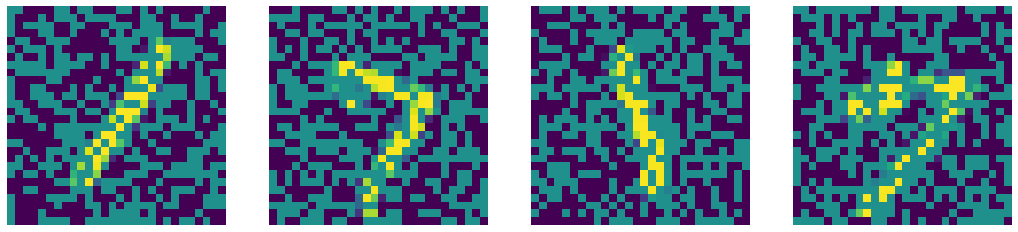

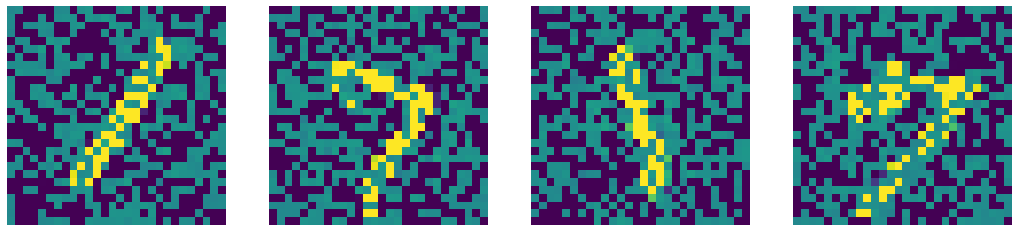

In [77]:
# try denoising 
num_epochs = 20

# corrupt images with 50% Dropout
do = nn.Dropout()

# increase number of hidden neurons for denoising AE
n_feat = 8
model = ConvolutionalAutoencoder(n_feat).to(device)
criterion = nn.MSELoss()

# reload optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

for epoch in range(num_epochs):
    for img, _ in dataloader:
        
        img = img.to(device)
        
        # introduce noisy img
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)
        
        # forward (feeding dropout image)
        output = model(img_bad)
        loss = criterion(output, img_bad.data)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # log + plot denoising AE
    print(f'Epoch [{epoch+1}/{num_epochs}, loss: {loss.item():.4f}]')
    
    if (epoch+1) % 4 == 0:
        display_images(img_bad, output)
        plt.show()